Created on Thu Oct 26 10:28:08 2023

@author: Santiago D'hers

Use:

- This script will help us visualize the results of labeled videos

Requirements:

- The position.csv files processed by 1-Manage_H5.py

- Geolabels, autolabels or manual labels

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle


import csv

In [2]:
# State your path:
base = r'C:\Users\dhers\OneDrive - UBA\workshop'
experiment = r'Interferencia'

path = os.path.join(base, experiment)
trials = ['Hab', 'TR1', 'TR2', 'TS']
groups = ['TORM_1h', 'TORM_3h', 'TeNOR_1h', 'TeNOR_3h']
objects = ['obj_1', 'obj_2']
novelty = ['Left', 'Right',
           'Old', 'Recent',
           'Novel', 'Known']

label_type = 'autolabels'

t_lim = None # seconds
fps = 25

# Define the color pairs for plotting
global color_A_list; color_A_list = ['dodgerblue',    'green',    'orangered',    'indigo',   'sienna']
global color_B_list; color_B_list = ['darkorange',    'orchid',   'turquoise',    'gray',     'limegreen']

In [3]:
def create_reference(folder, trials, objects):
    
    reference_path = os.path.join(folder, 'reference.csv')
    
    # Check if Reference.csv already exists
    if os.path.exists(reference_path):
        print("Reference file already exists")
        return reference_path
    
    all_labels_files=[]

    # Get a list of all CSV files in the labels folder
    for trial in trials:
        labels_files = glob(os.path.join(folder,f"{trial}/position/*position.csv"))
        labels_files = sorted(labels_files)
        all_labels_files += labels_files

    # Create a new CSV file with a header 'Videos'
    with open(reference_path, 'w', newline='') as output_file:
        csv_writer = csv.writer(output_file)
        col_list = ['Video', 'Group'] + objects
        csv_writer.writerow(col_list)

        # Write each position file name in the 'Videos' column
        for file in all_labels_files:
            # Remove "_position.csv" from the file name
            clean_name = os.path.basename(file).replace(f'_position.csv', '')
            csv_writer.writerow([clean_name])

    print(f"CSV file '{reference_path}' created successfully with the list of video files.")
    
    return reference_path

In [4]:
# Lets create the reference.csv file
reference_path = create_reference(path, trials, objects)

Reference file already exists


STOP! Go to the Reference file and complete the 'Group','Left' and 'Right' columns

In [5]:
def create_summary_folder(reference_path, trials, label_type, objects, fps = 30):
    
    parent_dir = os.path.dirname(reference_path)
    reference = pd.read_csv(reference_path)
    
    # Create a subfolder named "final_{label_type}"
    summary_path = os.path.join(parent_dir, f'summary')

    # Check if it exists
    if os.path.exists(summary_path):
        print(f'summary folder already exists')
    else:
        os.makedirs(summary_path, exist_ok = True)
    
    group_list = []
    
    # Iterate through each row in the table
    for index, row in reference.iterrows():
        
        video_name = row['Video']
        group = row['Group']

        group_path = os.path.join(summary_path, group)
        os.makedirs(group_path, exist_ok = True)

        for trial in trials:
            if trial in video_name:

                trial_path = os.path.join(group_path, trial)
                os.makedirs(trial_path, exist_ok = True)

                # Find the old file path & read the CSV file into a DataFrame
                old_movement_path = os.path.join(parent_dir, trial, 'movement', f'{video_name}_movement.csv')
                df_movement = pd.read_csv(old_movement_path)

                label_path = os.path.join(parent_dir, trial, f'{label_type}', f'{video_name}_{label_type}.csv')
                
                if os.path.exists(label_path):
                    df_label = pd.read_csv(label_path)

                    # Rename the columns based on the 'Left' and 'Right' values
                    for i in range(len(objects)):
                        obj = row[objects[i]]
                        df_label = df_label.rename(columns={objects[i]: obj})

                    df = pd.merge(df_movement, df_label, on='Frame')

                else:
                    df = df_movement

                df['Time'] = (df['Frame'] / fps).round(2)
                df = df[['Time'] + [col for col in df.columns if col != 'Time']]

                # Create the new file path
                new_name = f'{video_name}_summary.csv'
                new_path = os.path.join(trial_path, new_name)
        
                # Save the modified DataFrame to a new CSV file
                df.to_csv(new_path, index=False)
        
        group_list.append(group)
    
        print(f'Renamed and saved: {new_path}')
    
    group_list = sorted(list(set(group_list)))
        
    return summary_path, group_list

In [6]:
# Lets rename the labels
summary_path, groups = create_summary_folder(reference_path, trials, label_type, objects, fps)

summary folder already exists
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Interferencia\summary\TeNOR_1h\Hab\2023-11_Interferencia_Hab_R01_C01_A_L_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Interferencia\summary\TORM_1h\Hab\2023-11_Interferencia_Hab_R02_C01_A_R_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Interferencia\summary\TeNOR_3h\Hab\2023-11_Interferencia_Hab_R03_C01_B_L_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Interferencia\summary\TORM_3h\Hab\2023-11_Interferencia_Hab_R04_C01_B_R_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Interferencia\summary\TORM_3h\Hab\2023-11_Interferencia_Hab_R05_C02_A_L_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Interferencia\summary\TeNOR_3h\Hab\2023-11_Interferencia_Hab_R06_C02_A_R_summary.csv
Renamed and saved: C:\Users\dhers\OneDrive - UBA\workshop\Interferencia\summary\TORM_1h\Hab\2023-11_Interferencia_H

In [7]:
def calculate_DI(df: pd.DataFrame, novelty: list, fps: float = 30) -> pd.DataFrame:
    """
    Calculates the discrimination index (DI) between two exlpored objects.

    Args:
        df (pd.DataFrame): DataFrame containing the exploration times.
        novelty (list): List of the possible novelti values of the objects.
        fps (float, optional): Frames per second of the video. Defaults to 30.

    Returns:
        pd.DataFrame: DataFrame with the DI values.
    """
    i = 0 # This is probably not the best way to do this
    while i < len(novelty):
        A = novelty[i]
        B = novelty[i+1]
        # Check if columns A and B exist in the DataFrame
        if A not in df.columns or B not in df.columns:
            i+=2
        else:
            i = len(novelty)

    # Calculate cumulative sums
    df[f'{A}_cumsum'] = df[A].cumsum() / fps
    df[f'{B}_cumsum'] = df[B].cumsum() / fps
    df['DI'] = (df[f'{A}_cumsum'] - df[f'{B}_cumsum']) / (df[f'{A}_cumsum'] + df[f'{B}_cumsum']) * 100

    return df

In [8]:
def calculate_durations(series, fps=30):
    durations = []
    count = 0
    for value in series:
        if value > 0.5:
            count += 1
        else:
            if count >= fps//2:
                durations.append(count/fps)
                count = 0
    if count >= fps//2:
        durations.append(count/fps)
    return durations

In [9]:
def plot_exploration_time(path: str, group: str, trial: str, novelty: list, fps: int = 30, ax=None) -> None:
    """
    Plot the exploration time for each object for a single trial on a given axis.

    Args:
        path (str): Path to the main folder.
        group (str): Group name.
        trial (str): Trial name.
        novelty (list): Novelty condition for DI calculation.
        fps (int): Frames per second of the video.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. Creates a new figure if None.
    """
    if ax is None:
        fig, ax = plt.subplots()

    dfs = []
    folder = os.path.join(path, 'summary', group, trial)

    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder {folder} does not exist.")

    i = 0 # This is definately not the best way to do this
    for file_path in glob(os.path.join(folder, "*summary.csv")):
        df = pd.read_csv(file_path)
        df = calculate_DI(df, novelty, fps)

        while i < len(novelty):
            A = novelty[i]
            B = novelty[i+1]
            # Check if columns A and B exist in the DataFrame
            if A not in df.columns or B not in df.columns:
                i+=2
            else:
                i = len(novelty)
                
        dfs.append(df)

    if not dfs:
        raise ValueError("No valid data files were found.")
    
    n = len(dfs)
    se = np.sqrt(n) if n > 1 else 1

    min_length = min([len(df) for df in dfs])
    trunc_dfs = [df.iloc[:min_length].copy() for df in dfs]

    all_dfs = pd.concat(trunc_dfs, ignore_index=True)

    df = all_dfs.groupby('Frame').agg(['mean', 'std']).reset_index()
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    # Define a list of colors (you can expand this as needed)
    color_A = color_A_list[aux_glob]
    color_B = color_B_list[aux_glob]

    # Object exploration
    ax.plot(df['Time_mean'], df[f'{A}_cumsum_mean'], label = f'{group} {A}', color = color_A, marker='_')
    ax.fill_between(df['Time_mean'], df[f'{A}_cumsum_mean'] - df[f'{A}_cumsum_std'] /se, df[f'{A}_cumsum_mean'] + df[f'{A}_cumsum_std'] /se, color = color_A, alpha=0.2)
    ax.plot(df['Time_mean'], df[f'{B}_cumsum_mean'], label = f'{group} {B}', color = color_B, marker='_')
    ax.fill_between(df['Time_mean'], df[f'{B}_cumsum_mean'] - df[f'{B}_cumsum_std'] /se, df[f'{B}_cumsum_mean'] + df[f'{B}_cumsum_std'] /se, color = color_B, alpha=0.2)
    ax.set_xlabel('Time (s)')
    max_time = df['Time_mean'].max()
    ax.set_xticks(np.arange(0, max_time + 30, 60))    
    ax.set_ylabel('Exploration Time (s)')
    ax.set_title('Exploration of objects during TS')
    ax.legend(loc='best', fancybox=True, shadow=True)
    ax.grid(True)

In [10]:
def plot_exploration_boxplot(path: str, group: str, trial: str, novelty: list, fps: int = 30, ax=None) -> None:
    """
    Plot a boxplot of exploration time for each object at the end of the session

    Args:
        path (str): Path to the main folder.
        group (str): Group name.
        trial (str): Trial name.
        novelty (list): Novelty condition for DI calculation.
        fps (int): Frames per second of the video.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. Creates a new figure if None.

    Returns:
        None
    """
    if ax is None:
        fig, ax = plt.subplots()

    bxplt = []
    folder = os.path.join(path, 'summary', group, trial)

    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder {folder} does not exist.")
    
    i = 0 # This is definately not the best way to do this
    for file_path in glob(os.path.join(folder, "*summary.csv")):
        df = pd.read_csv(file_path)
        df = calculate_DI(df, novelty, fps)

        while i < len(novelty):
            A = novelty[i]
            B = novelty[i+1]
            # Check if columns A and B exist in the DataFrame
            if A not in df.columns or B not in df.columns:
                i+=2
            else:
                i = len(novelty)
        
        bxplt.append([df.loc[df.index[-1], f'{A}_cumsum'], df.loc[df.index[-1], f'{B}_cumsum']])
    
    bxplt = pd.DataFrame(bxplt, columns = [A, B])

    # Dynamically calculate x-axis positions using a global auxiliary variable
    group_positions = [aux_glob, aux_glob + 0.4]

    # Define a list of colors (you can expand this as needed)
    color_A = color_A_list[aux_glob]
    color_B = color_B_list[aux_glob]

    # Boxplot
    ax.boxplot(bxplt[A], positions=[group_positions[0]], tick_labels=[f'{group}\n{A}'])
    ax.boxplot(bxplt[B], positions=[group_positions[1]], tick_labels=[f'{group}\n{B}'])
    
    # Replace boxplots with scatter plots with jitter
    jitter = 0.05  # Adjust the jitter amount as needed
    ax.scatter([group_positions[0] + np.random.uniform(-jitter, jitter) for _ in range(len(bxplt[A]))], bxplt[A], color=color_A, alpha=0.7)
    ax.scatter([group_positions[1] + np.random.uniform(-jitter, jitter) for _ in range(len(bxplt[B]))], bxplt[B], color=color_B, alpha=0.7)
    
    # Add lines connecting points from the same row
    for row in bxplt.index:
        index_a = group_positions[0]
        index_b = group_positions[1]
        ax.plot([index_a + np.random.uniform(-jitter, jitter), index_b + np.random.uniform(-jitter, jitter)],
                        [bxplt.at[row, A], bxplt.at[row, B]], color='gray', linestyle='-', linewidth=0.5)
    # Add mean lines
    mean_a = np.mean(bxplt[A])
    mean_b = np.mean(bxplt[B])
    ax.axhline(mean_a, color=color_A, linestyle='--', label=f'{group} {A}')
    ax.axhline(mean_b, color=color_B, linestyle='--', label=f'{group} {B}')
    ax.set_ylabel('Exploration Time (s)')
    ax.set_title('Exploration of objects at the end of TS')
    ax.legend(loc='best', fancybox=True, shadow=True)
    ax.grid(True)

In [11]:
def plot_exploration_histogram(path: str, group: str, trial: str, novelty: list, fps: int = 30, ax=None) -> None:
    """
    Plot an histogram of the durations of the exploration of each object.

    Args:
        path (str): Path to the main folder.
        group (str): Group name.
        trial (str): Trial name.
        novelty (list): Novelty condition for DI calculation.
        fps (int): Frames per second of the video.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. Creates a new figure if None.

    Returns:
        None
    """
    if ax is None:
        fig, ax = plt.subplots()

    dfs = []
    folder = os.path.join(path, 'summary', group, trial)

    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder {folder} does not exist.")

    i = 0 # This is definately not the best way to do this
    for file_path in glob(os.path.join(folder, "*summary.csv")):
        df = pd.read_csv(file_path)
        df = calculate_DI(df, novelty, fps)

        while i < len(novelty):
            A = novelty[i]
            B = novelty[i+1]
            # Check if columns A and B exist in the DataFrame
            if A not in df.columns or B not in df.columns:
                i+=2
            else:
                i = len(novelty)

        dfs.append(df)

    if not dfs:
        raise ValueError("No valid data files were found.")
    
    n = len(dfs)
    se = np.sqrt(n) if n > 1 else 1

    min_length = min([len(df) for df in dfs])
    trunc_dfs = [df.iloc[:min_length].copy() for df in dfs]

    all_dfs = pd.concat(trunc_dfs, ignore_index=True)

    df = all_dfs.groupby('Frame').agg(['mean', 'std']).reset_index()
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    # Define a list of colors (you can expand this as needed)
    color_A = color_A_list[aux_glob]
    color_B = color_B_list[aux_glob]

    # Histogram of exploration event durations
    A_durations = []
    B_durations = []
    for df in trunc_dfs:
        A_durations.extend(calculate_durations(df[A], fps=fps))
        B_durations.extend(calculate_durations(df[B], fps=fps))
    # n_bins = int((np.sqrt(len(A_durations))) + np.sqrt(len(B_durations))) // 2
    n_bins = 20
    
    ax.hist(A_durations, bins=n_bins, alpha=0.5, color=color_A, label = f'{group} {A}')
    ax.hist(B_durations, bins=n_bins, alpha=0.5, color=color_B, label = f'{group} {B}')
    ax.set_xlabel('Duration (s)')
    ax.set_ylabel('Events')
    ax.legend(loc='best', fancybox=True, shadow=True)
    ax.set_title('Histogram of Exploration Durations')
    ax.set_xlim([0, None])

In [12]:
def plot_DI(path: str, group: str, trial: str, novelty: list, fps: int = 30, ax=None) -> None:
    """
    Plot the Discrimination Index (DI) for a single trial on a given axis.

    Args:
        path (str): Path to the main folder.
        group (str): Group name.
        trial (str): Trial name.
        novelty (list): Novelty condition for DI calculation.
        fps (int): Frames per second of the video.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. Creates a new figure if None.

    Returns:
        None
    """
    if ax is None:
        fig, ax = plt.subplots()

    dfs = []
    folder = os.path.join(path, 'summary', group, trial)

    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder {folder} does not exist.")

    for file_path in glob(os.path.join(folder, "*summary.csv")):
        df = pd.read_csv(file_path)
        df = calculate_DI(df, novelty, fps)
        dfs.append(df)

    if not dfs:
        raise ValueError("No valid data files were found.")
    
    n = len(dfs)
    se = np.sqrt(n) if n > 1 else 1

    min_length = min([len(df) for df in dfs])
    trunc_dfs = [df.iloc[:min_length].copy() for df in dfs]

    all_dfs = pd.concat(trunc_dfs, ignore_index=True)

    df = all_dfs.groupby('Frame').agg(['mean', 'std']).reset_index()
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    # Define a list of colors (you can expand this as needed)
    color = color_A_list[aux_glob]  # Assign color based on group name

    ax.plot(df['Time_mean'], df['DI_mean'], label=f'{group} DI', color=color, linestyle='--')
    ax.fill_between(
        df['Time_mean'], 
        df['DI_mean'] - df['DI_std'] / se, 
        df['DI_mean'] + df['DI_std'] / se, 
        color=color, alpha=0.2
    )
    ax.set_xlabel('Time (s)')
    max_time = df['Time_mean'].max()
    ax.set_xticks(np.arange(0, max_time + 30, 60))
    ax.set_ylabel('DI (%)')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=2)
    ax.set_title(f"{trial}")
    ax.legend(loc='best', fancybox=True, shadow=True)
    ax.grid(True)

In [13]:
def plot_distance(path: str, group: str, trial: str, novelty: list, fps: int = 30, ax=None) -> None:
    """
    Plot the distance traveled by the mouse.

    Args:
        path (str): Path to the main folder.
        group (str): Group name.
        trial (str): Trial name.
        novelty (list): Novelty condition for DI calculation.
        fps (int): Frames per second of the video.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. Creates a new figure if None.

    Returns:
        None
    """
    if ax is None:
        fig, ax = plt.subplots()

    A = 'nose_dist'
    B = 'body_dist'

    dfs = []
    folder = os.path.join(path, 'summary', group, trial)

    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder {folder} does not exist.")

    for file_path in glob(os.path.join(folder, "*summary.csv")):
        df = pd.read_csv(file_path)
        df[f'{A}_cumsum'] = df[A].cumsum() / fps
        df[f'{B}_cumsum'] = df[B].cumsum() / fps
        dfs.append(df)

    if not dfs:
        raise ValueError("No valid data files were found.")
    
    n = len(dfs)
    se = np.sqrt(n) if n > 1 else 1

    min_length = min([len(df) for df in dfs])
    trunc_dfs = [df.iloc[:min_length].copy() for df in dfs]

    all_dfs = pd.concat(trunc_dfs, ignore_index=True)

    df = all_dfs.groupby('Frame').agg(['mean', 'std']).reset_index()
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    # Define a list of colors (you can expand this as needed)
    color_A = color_A_list[aux_glob]
    color_B = color_B_list[aux_glob]

    # Distance covered
    ax.plot(df['Time_mean'], df[f'{A}_cumsum_mean'], label = f'{group} {A}', color = color_A)
    ax.fill_between(df['Time_mean'], df[f'{A}_cumsum_mean'] - df[f'{A}_cumsum_std'] /se, df[f'{A}_cumsum_mean'] + df[f'{A}_cumsum_std'] /se, color = color_A, alpha=0.2)
    ax.plot(df['Time_mean'], df[f'{B}_cumsum_mean'], label = f'{group} {B}', color = color_B)
    ax.fill_between(df['Time_mean'], df[f'{B}_cumsum_mean'] - df[f'{B}_cumsum_std'] /se, df[f'{B}_cumsum_mean'] + df[f'{B}_cumsum_std'] /se, color = color_B, alpha=0.2)
    ax.set_xlabel('Time (s)')
    max_time = df['Time_mean'].max()
    ax.set_xticks(np.arange(0, max_time + 30, 60))    
    ax.set_ylabel('Distance traveled (cm)')
    ax.legend(loc='best', fancybox=True, shadow=True)
    ax.grid(True)

In [14]:
def plot_freezing(path: str, group: str, trial: str, novelty: list, fps: int = 30, ax=None) -> None:
    """
    Plot the time the mouse spent freezing.

    Args:
        path (str): Path to the main folder.
        group (str): Group name.
        trial (str): Trial name.
        novelty (list): Novelty condition for DI calculation.
        fps (int): Frames per second of the video.
        ax (matplotlib.axes.Axes, optional): Axis to plot on. Creates a new figure if None.

    Returns:
        None
    """
    if ax is None:
        fig, ax = plt.subplots()

    A = 'freezing'

    dfs = []
    folder = os.path.join(path, 'summary', group, trial)

    if not os.path.exists(folder):
        raise FileNotFoundError(f"Folder {folder} does not exist.")

    for file_path in glob(os.path.join(folder, "*summary.csv")):
        df = pd.read_csv(file_path)
        df[f'{A}_cumsum'] = df[A].cumsum() / fps
        dfs.append(df)

    if not dfs:
        raise ValueError("No valid data files were found.")
    
    n = len(dfs)
    se = np.sqrt(n) if n > 1 else 1

    min_length = min([len(df) for df in dfs])
    trunc_dfs = [df.iloc[:min_length].copy() for df in dfs]

    all_dfs = pd.concat(trunc_dfs, ignore_index=True)

    df = all_dfs.groupby('Frame').agg(['mean', 'std']).reset_index()
    df.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]

    # Define a list of colors (you can expand this as needed)
    color = color_A_list[aux_glob]  # Assign color based on group name

    # Distance covered
    ax.plot(df['Time_mean'], df[f'{A}_cumsum_mean'], label = f'{group} {A}', color = color)
    ax.fill_between(df['Time_mean'], df[f'{A}_cumsum_mean'] - df[f'{A}_cumsum_std'] /se, df[f'{A}_cumsum_mean'] + df[f'{A}_cumsum_std'] /se, color = color, alpha=0.2)
    ax.set_xlabel('Time (s)')
    max_time = df['Time_mean'].max()
    ax.set_xticks(np.arange(0, max_time + 30, 60))    
    ax.set_ylabel('Time freezing (s)')
    ax.legend(loc='best', fancybox=True, shadow=True)
    ax.grid(True)

In [15]:
def plot_multiple_analyses(path: str, groups: list, plot_list: list, trial: str, novelty: list, fps: int = 30, show: bool = True) -> None:
    """
    Plot multiple analyses for a single trial side by side as subplots.

    Args:
        path (str): Path to the main folder.
        groups (list): List of group names.
        trial (str): Trial name.
        novelty (list): List of novelty values.
        fps (int): Frames per second of the video.
        plot_list (list): List of functions to apply for plotting.
        show (bool): Whether to display the plots.

    Returns:
        None: Displays the plots and optionally saves them.
    """
    # Number of plots to create
    num_plots = len(plot_list)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5), sharey=False)

    # Ensure axes is always iterable (if only one plot, make it a list)
    if num_plots == 1:
        axes = [axes]

    global aux_glob

    # Loop through each plot function in plot_list and create a separate subplot for it
    for ax, plot_func in zip(axes, plot_list):
        aux_glob = 0
        # Loop through groups and plot each group separately on the current ax
        for group in groups:
            try:
                # Call the plotting function for each group on the current subplot axis
                plot_func(path, group, trial, novelty, fps, ax=ax)
                aux_glob += 1
            except Exception as e:
                print(f"Error plotting {plot_func.__name__} for group {group} and trial {trial}: {e}")
                ax.set_title(f"Error in {plot_func.__name__}")
                continue
        
        # Set a title for each subplot indicating the function being plotted
        ax.set_title(f"{plot_func.__name__}")

    # Adjust layout to prevent overlapping of titles and axis labels
    plt.suptitle(f"{os.path.basename(path)} - Multiple Analyses\nGroups: {', '.join(groups)}; Trial: {trial}")
    plt.tight_layout()  # Adjust spacing to fit titles

    # Optionally show the plot
    if show:
        plt.show()

Error plotting plot_exploration_time for group TORM_1h and trial Hab: 'Novel'
Error plotting plot_exploration_time for group TORM_3h and trial Hab: 'Novel'
Error plotting plot_exploration_time for group TeNOR_1h and trial Hab: 'Novel'
Error plotting plot_exploration_time for group TeNOR_3h and trial Hab: 'Novel'
Error plotting plot_exploration_boxplot for group TORM_1h and trial Hab: 'Novel'
Error plotting plot_exploration_boxplot for group TORM_3h and trial Hab: 'Novel'
Error plotting plot_exploration_boxplot for group TeNOR_1h and trial Hab: 'Novel'
Error plotting plot_exploration_boxplot for group TeNOR_3h and trial Hab: 'Novel'
Error plotting plot_exploration_histogram for group TORM_1h and trial Hab: 'Novel'
Error plotting plot_exploration_histogram for group TORM_3h and trial Hab: 'Novel'
Error plotting plot_exploration_histogram for group TeNOR_1h and trial Hab: 'Novel'
Error plotting plot_exploration_histogram for group TeNOR_3h and trial Hab: 'Novel'


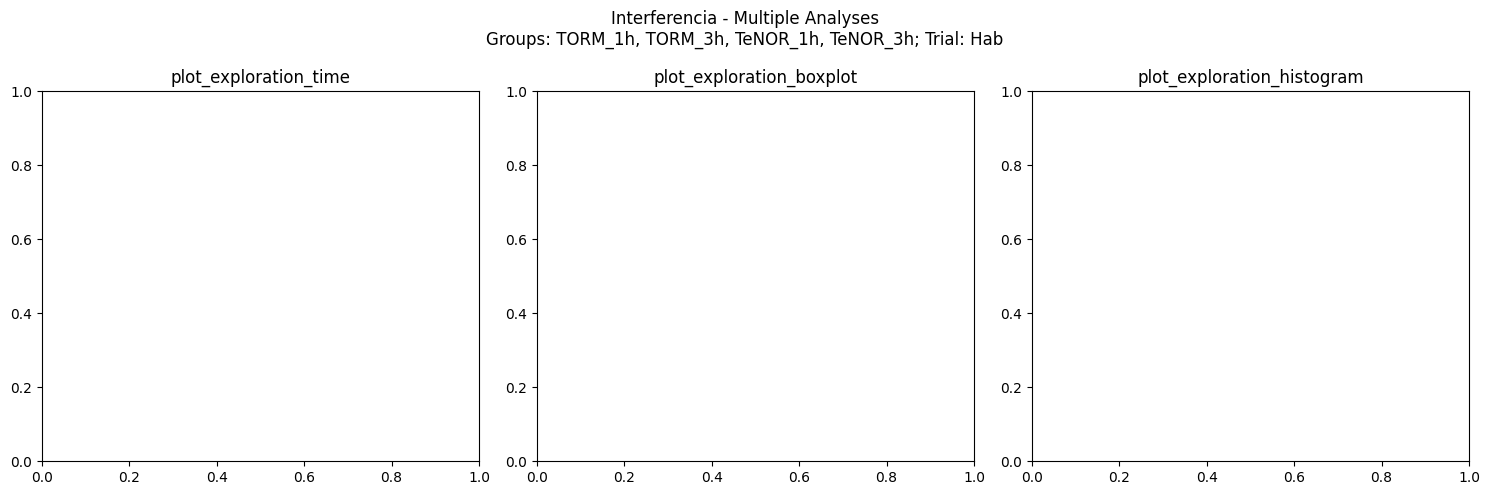

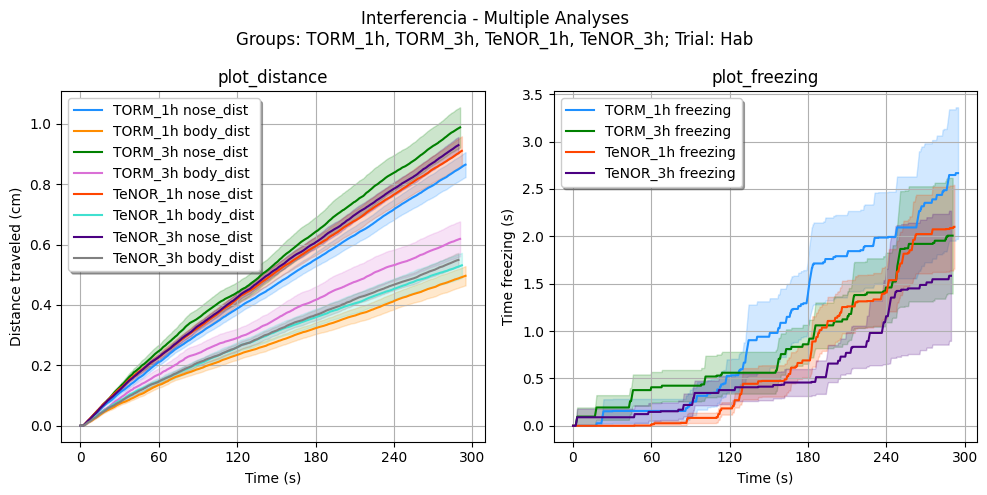

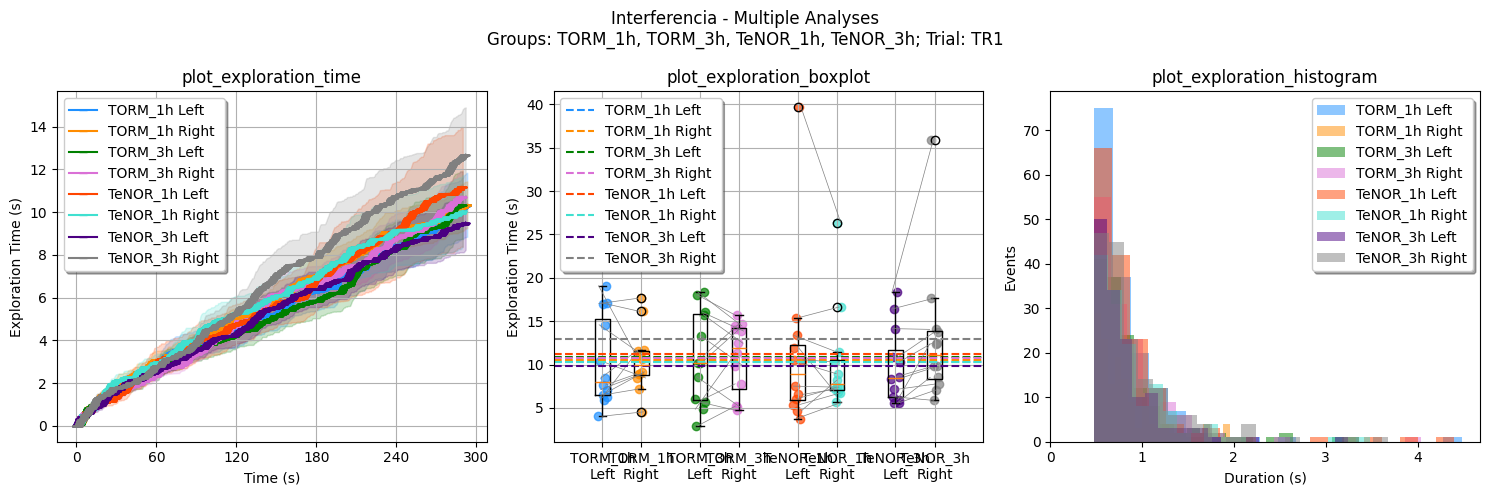

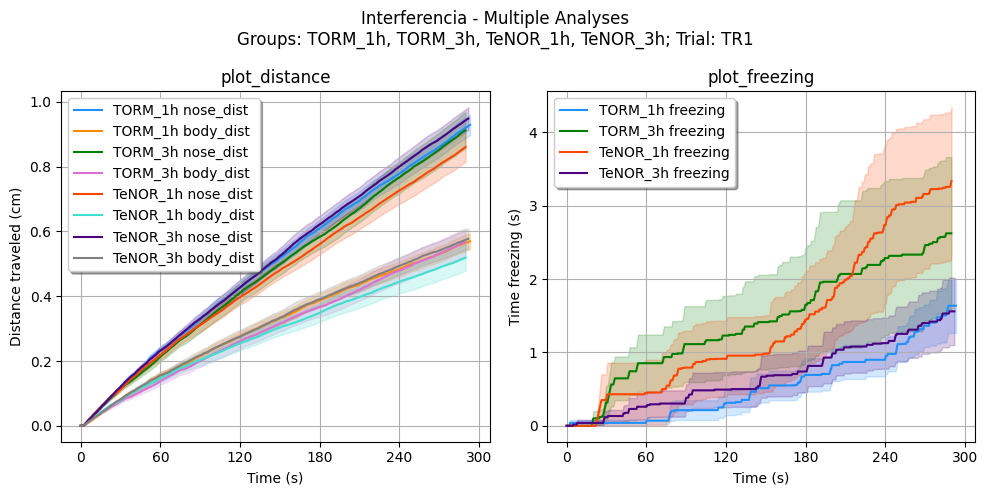

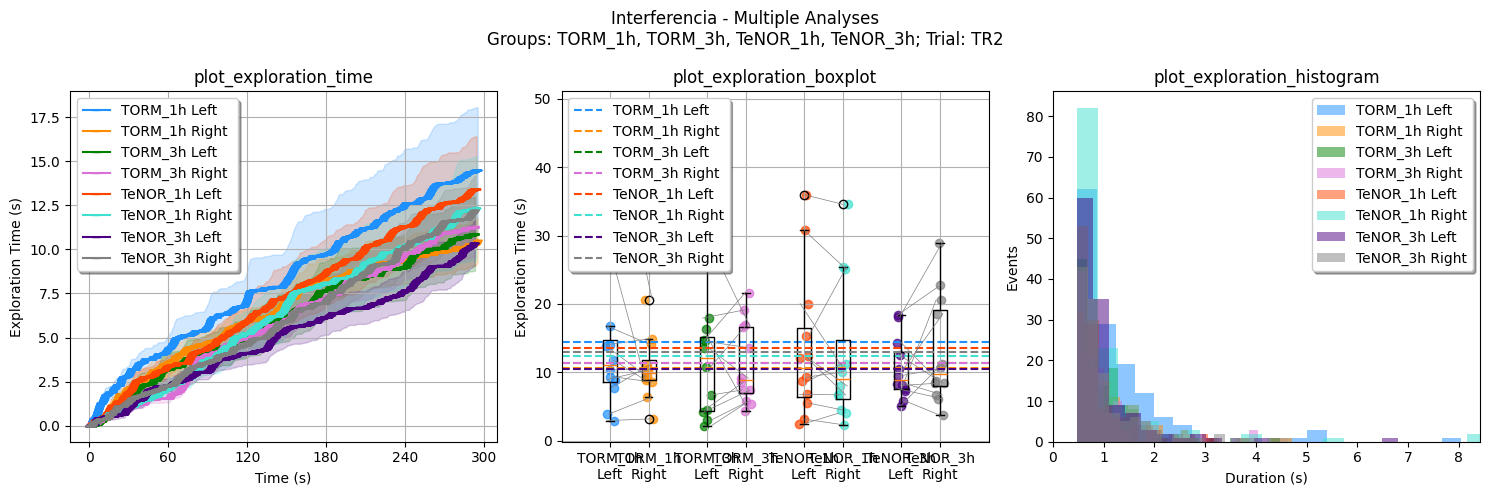

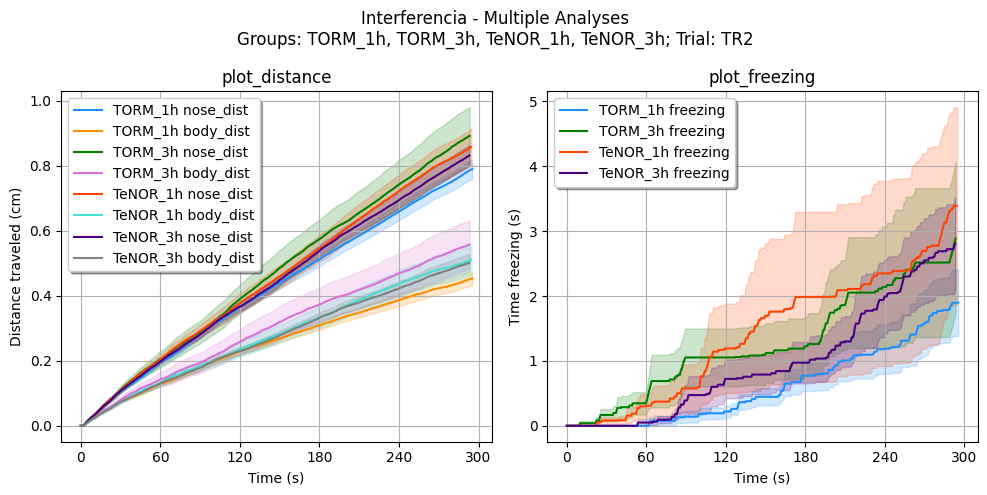

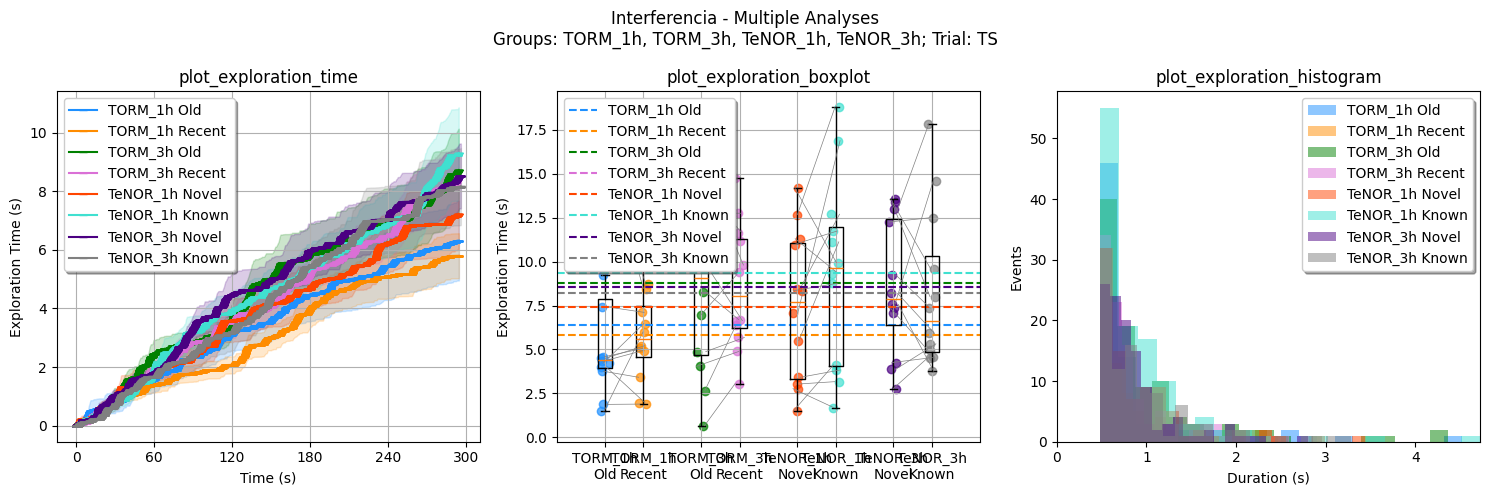

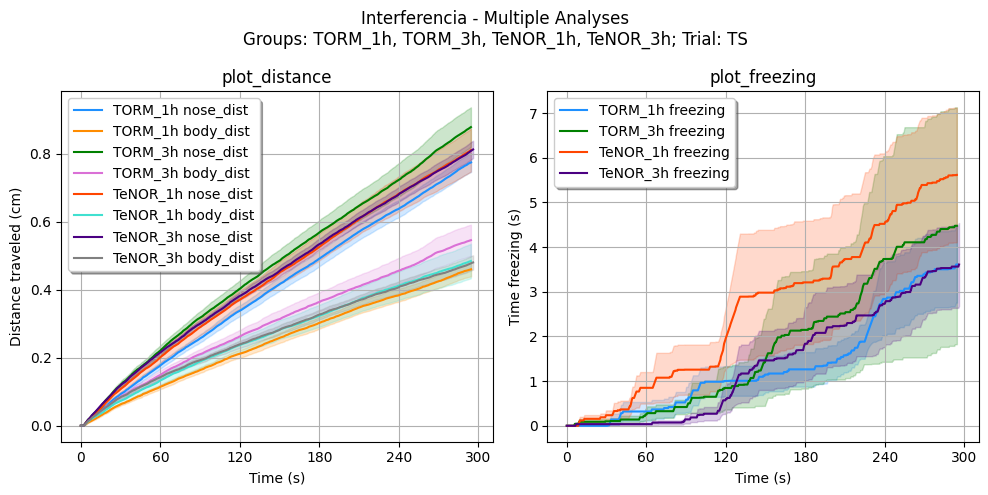

In [16]:
plot_list_1 = [plot_exploration_time, plot_exploration_boxplot, plot_exploration_histogram]
plot_list_2 = [plot_distance, plot_freezing]

for trial in trials:
    plot_multiple_analyses(path, groups, plot_list_1, trial, novelty, fps)
    plot_multiple_analyses(path, groups, plot_list_2, trial, novelty, fps)